In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# %cd '/content/gdrive/MyDrive/Virginia Tech /Fall 2022/Codes from GPU/PINN_Stan/1D FODE/atanh'

In [4]:
# !pip install smt

In [5]:
def g(x):
    y = np.zeros((x.shape[0],1))
    
    for i in range(x.shape[0]):
        k = x[i]
        if(k<0.25):
            y[i] = 4.0
        elif(k<=0.5):
            y[i] = 0.0
        elif(k<=0.75):
            y[i] = 4.0
        elif(k<=1.0):
            y[i] = 1.5
        elif(k<=1.25):
            y[i] = 3.0
        elif(k<=1.50):
            y[i] = 0.0
        elif(k<=1.75):
            y[i] = 4.0
        else:
            y[i] = 0.0
            
    return y

In [6]:
def true_adv(xt): #True function for 2D_4 Heat Transfer in a rod x \in [0,1] t \in [0,0.1]
    q = g(xt[:,0].reshape(-1,1) - ubar*xt[:,1].reshape(-1,1))
    return q

In [7]:
ubar = 0.5
loss_thresh = 0.1
label = "Adv_tanh"

x_ll = np.array(0.0)
x_ul = np.array(2.0)

x = np.linspace(x_ll,x_ul,500).reshape(-1,1)
t = np.linspace(0,0.2,500).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

u_true = true_adv(xt)
u_true_norm = np.linalg.norm(u_true,2)


lb_xt = xt[0]
ub_xt = xt[-1]

xt_test_tensor = torch.from_numpy(xt).float().to(device)

In [8]:
def trainingdata(N_I,N_D,N_f,seed):
    
    np.random.seed(seed)
    
    #X_Train
    np.random.seed(seed)
    x_IC = np.random.uniform(x_ll,x_ul,(N_I,1))
    t_IC = np.zeros((N_I,1))
    xt_IC = np.hstack((x_IC,t_IC))
    u_IC = g(x_IC)
    
    x_BC1 = x_ll*np.ones((N_D,1))
    t_BC1 = np.random.uniform(0,0.2,(N_D,1))
    xt_BC1 = np.hstack((x_BC1,t_BC1))
    
    x_BC2 = x_ul*np.ones((N_D,1))
    t_BC2 = np.random.uniform(0,0.2,(N_D,1))
    xt_BC2 = np.hstack((x_BC2,t_BC2))
    
    xt_BC = np.vstack((xt_BC1,xt_BC2))
    u_BC = true_adv(xt_BC)
    
    xt_train = np.vstack((xt_IC,xt_BC))
    u_train = np.vstack((u_IC,u_BC))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)

    samples = sampling(N_f)
    
    xt_coll = lb_xt + (ub_xt - lb_xt)*samples
    
    xt_coll = np.vstack((xt_coll,xt_train)) # append training points to collocation points 

    return xt_coll, xt_train, u_train

In [9]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.m_lambda = nn.Sigmoid()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        
        
        self.lambdas_BC = Parameter(torch.ones(2*N_D+N_I,1))
        self.lambdas_BC.requiresGrad = True
        
        self.lambdas_f = Parameter(torch.ones(N_f+2*N_D+N_I,1))
        self.lambdas_f.requiresGrad = True

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = 2.0*(xt - lbxt)/(ubxt - lbxt) - 1.0
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
             
        a = self.linears[-1](a) 
         
        return a
    
    def loss_BC(self,xt,u,lambda_ind):
        
        m = self.m_lambda(self.lambdas_BC)
        u_pred = self.forward(xt)
        
        if(lambda_ind):
            u_pred = u_pred.detach()
        else:
            m = m.detach()
            
        loss_bc1 = torch.sum(m*torch.square(u_pred - u))/2.0
        
        # loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
                        
    
    def loss_PDE(self, xt_coll,f_hat,lambda_ind):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_t = autograd.grad(u,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        du_dx = u_x_t[:,[0]]
                
        du_dt = u_x_t[:,[1]]
        
        f = du_dt + ubar*du_dx
        
        m = self.m_lambda(self.lambdas_f)
        
        if(lambda_ind):
            f = f.detach()
        else:
            m = m.detach()
        
        # loss_f = self.loss_function(f,f_hat)
        loss_f = (N_f+2*N_D+N_I)*self.loss_function(m*(torch.square(f)),f_hat)/2.0
                
        return loss_f
    
    def loss(self,xt_coll,f_hat, xt_train, u_train):

        lambda_ind = False
        loss_f = self.loss_PDE(xt_coll,f_hat,lambda_ind)
        
        loss_train = self.loss_BC(xt_train,u_train,lambda_ind)
        
        loss_val = loss_f + loss_train
    
        return loss_val
    
    def loss_lambdas(self,xt_coll,f_hat, xt_train, u_train):

        lambda_ind = True
        loss_f = self.loss_PDE(xt_coll,f_hat,lambda_ind)
        
        loss_train = self.loss_BC(xt_train,u_train,lambda_ind)
        
        loss_val = loss_f + loss_train
    
        return -1.0*loss_val
     
    'callable for optimizer'                                    
    
    def test(self):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 

In [10]:
def train_step(xt_coll,f_hat, xt_train, u_train,seed):    
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xt_coll,f_hat, xt_train, u_train)
        loss.backward()
        
        return loss

    optimizer.step(closure)
    
    for i in range(30):
        optimizer_lambda.zero_grad()
        loss = PINN.loss_lambdas(xt_coll,f_hat, xt_train, u_train)
        loss.backward()
        optimizer_lambda.step()
        

In [11]:
def data_update(loss_np):
    train_loss.append(loss_np)
    # beta_val.append(PINN.beta.cpu().detach().numpy())
    # lambda1_val.append(PINN.lambda1.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)
    
  

In [12]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*11)
    start_time = time.time() 
    thresh_flag = 0
    
    xt_coll, xt_train, u_train = trainingdata(N_I,N_D,N_f,123)
    
    xt_coll = torch.from_numpy(xt_coll).float().to(device)
    xt_train = torch.from_numpy(xt_train).float().to(device)
    u_train = torch.from_numpy(u_train).float().to(device)
    
    
    f_hat = torch.zeros(xt_coll.shape[0],1).to(device)

    for i in range(max_iter):
        train_step(xt_coll,f_hat, xt_train, u_train,i)

        loss_np = PINN.loss(xt_coll,f_hat, xt_train, u_train).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])


    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [13]:
max_reps = 1 #10
max_iter = 500 #75

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []

lambda1_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 1.0

N_I = 1000
N_D = 1000
N_f = 5000

for reps in range(max_reps):
    print(label)
    'Generate Training data'
    print(reps)
    torch.manual_seed(reps*36)

    train_loss = []
    test_mse_loss = []
    test_re_loss = []   
    beta_val = []

    lambda1_val = []



    layers = np.array([2,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers,beta_init)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())

    optimizer = torch.optim.LBFGS(PINN.parameters(), lr= 1.0, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-8, 
                              tolerance_change = 1e-8, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer_lambda = torch.optim.Adam(PINN.parameters(), lr=0.1)


    nan_flag = train_model(max_iter,reps)

    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)

    lambda1_full.append(lambda1_val)


    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full,"lambda1": lambda1_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic) 


Adv_tanh
0
Sequentialmodel(
  (activation): Tanh()
  (m_lambda): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1569.1259 Test MSE 3.315175394759438 Test RE 0.6517411583137798
1 Train Loss 1552.8293 Test MSE 3.2534799633113023 Test RE 0.6456482246201822
2 Train Loss 1541.7631 Test MSE 3.2416096915579926 Test RE 0.6444693295192309
3 Train Loss 1528.0326 Test MSE 3.198264648877749 Test RE 0.6401460820809141
4 Train Loss 1487.1212 Test MSE 3.1014403452764165 Test RE 0.630381717291278
5 Train Loss 1365.6827 Test MSE 2.808643368441322 Test RE 0.5998880237314947
6 Train Loss 1298.655 Test MSE 2.658650918178455 Test RE 0.583650083449732
7 Train Loss 1185.6132 Test MSE 2.3997893283853453 Test RE 0.5545088115507041
8 Train 

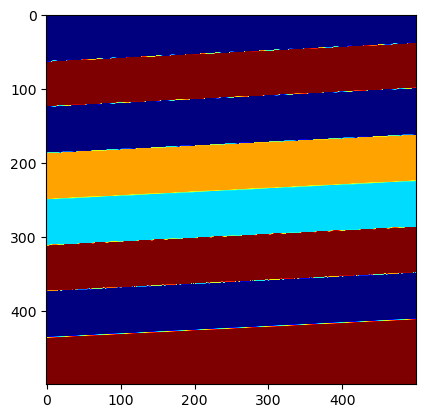

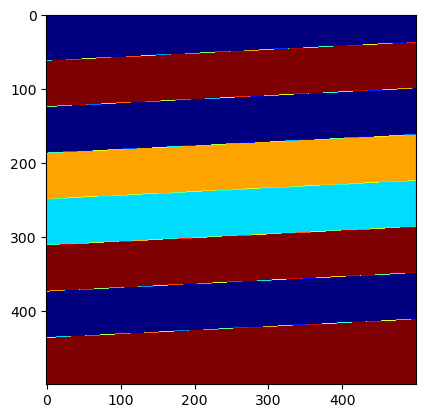

In [14]:
u_pred= PINN.test()
plt.imshow(np.flip(u_pred.reshape(500,500),axis = 0),cmap = 'jet',vmax = 4,vmin = 0.2)
plt.figure()
plt.imshow(np.flip(u_true.reshape(500,500),axis = 0),cmap = 'jet',vmax = 4,vmin = 0.2)